In [1]:
# for use in tutorial and development; do not include this `sys.path` change in production:
import sys ; sys.path.insert(0, "../")

# Explain PyTextRank: the algorithm

Let's look at the *TextRank* algorithm used to build a graph from a raw text, and then from that extract the top-ranked phrases. This work is based on 
["TextRank: Bringing Order into Text"](http://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf),
Rada Mihalcea, Paul Tarau, _Empirical Methods in Natural Language Processing_ (2004).

---
First we perform some basic housekeeping for Jupyter, then load `spaCy` with a language model for English ...

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [4]:
import pandas as pd
import pytextrank
import spacy
from spacy.tokens import Span
from germalemma import GermaLemma

In [5]:
data = pd.read_csv("/home/pawan/Questionnaire_new_version.csv") # first 19 documents with their ground truth

In [6]:
data

,Documents,file_name,Text,Ground_Truth
0,document1,Nacaps-W1_questionnaire,"""Die Hochschule, an der Sie im Dezember 2018 z...","'wissenschaftssystem', 'betreuung', 'wissensch..."
1,document2,WeGe_W2,"""Wie ist dieser studienvorbereitende Kurs verl...","'integration', 'geflüchtete', 'studienkolleg',..."
2,document3,StuMa2020,"""Welchen Studienabschluss haben Sie in Ihrem l...","'beruflicher verbleib von exmatrikulierten', '..."
3,document4,Studierdenensurvey2016,"""An welcher Art Hochschule studieren Sie. Univ...","'evaluation', 'qualifikation', 'effizienz', 's..."
4,document5,Absolventen_2009.2_Haupt,"""Wie würden Sie Ihre derzeitige Tätigkeit bzw....",'hochschulforschung'
5,document6,Promopanel_W4,"""Waren oder sind Sie seit der letzten Befragun...","'promotion', 'hochschulforschung', 'promotion'..."
6,document7,Studienberechtigte_2008.3,"""Wie zufrieden sind Sie mit Ihrem bisherigen B...","'studienberechtigte', 'hochschulforschung'"
7,document8,Wissenschaftlerbefragung2016,"""In welcher Sprache möchten Sie die Befragung ...",'hochschulforschung'
8,document9,Promopanel_W3,"""Waren oder sind Sie seit der letzten Befragun...","'promotion', 'hochschulforschung', 'promotion'..."
9,document10,Sozialerhebung20,"""Welchen Abschluss streben Sie in Ihrem derzei...",'hochschulforschung'


In [7]:
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import pickle
import sklearn
import numpy as np
import nltk 

nltk.download('punkt')
nltk.download('stopwords')

# stemmer = SnowballStemmer("german")

[nltk_data] Downloading package punkt to /home/pawan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/pawan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
def clean_text(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
         #Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž.! ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            word for word in words_tokens_lower if word not in stop_words
        ] 

    text_clean = " ".join(words_filtered)
    return text_clean

In [9]:
data["clean_text"] = data["Text"].map(
    lambda x: clean_text(x, for_embedding=True) if isinstance(x, str) else x
)

In [10]:
data["clean_text"][0]

'Die Hochschule an der Sie im Dezember zur Promotion registriert waren hat ebenfalls Interesse daran mehr über die Promotionsbedingungen ihrer Promovierenden zu erfahren . Um Doppelbefragungen zu vermeiden möchten wir die von Ihnen innerhalb dieses Fragebogens angegebenen Antworten an Ihre Hochschule zum Zweck der Qualitätssicherung und Evaluation im Bereich der Doktorandenausbildung Ihr Einverständnis vorausgesetzt weiter geben . Ja ich bin mit der Weitergabe meiner Angaben an die Hochschule einverstanden . Nein ich bin mit der Weitergabe meiner Angaben an die Hochschule nicht einverstanden . Anfang Dezember waren Sie an Ihrer Hochschule offiziell als Doktorand in registriert . In der Zwischenzeit kann sich daran etwas geändert haben . Bitte geben Sie an was aktuell auf Sie zutrifft . Ich promoviere . Ich habe das Promotionsverfahren abgeschlossen . Ich habe mein Promotionsvorhaben unterbrochen . Ich habe mein Promotionsvorhaben abgebrochen . Handelt es sich um eine offiziell der Hoch

In [11]:
Preprocesed_text = []
for i in range(len(data["clean_text"])):
    Preprocesed_text.append(re.sub(r'\s([?.!"](?:\s|$))', r'\1', data["clean_text"][i]))  

In [12]:
import re
test_text = []
for i in range(len(Preprocesed_text)):
    test_text.append(re.sub(r'\.+ ', ".",  Preprocesed_text[i]))

In [13]:
cleaned_text = []
for i in range(len(test_text)):
    for line in test_text[i].split('\n'):
        # Replace multiple dots with space
        line = re.sub('\.\.+', '.', line) 
        # Remove single dots
        cleaned_text.append(re.sub('\.', '.', line))

In [14]:
final_cleaned_text = []
for i in range(len(cleaned_text)):
    final_cleaned_text.append(re.sub(r"\.(?=\S)", ". ", cleaned_text[i]))

In [15]:
# test = final_cleaned_text[1]

In [16]:
final_cleaned_text[1]

'Wie ist dieser studienvorbereitende Kurs verlaufen. Dieser Kurs ist noch nicht beendet und ich besuche Ihn zurzeit weiterhin. Dieser Kurs ist beendet und ich habe an einer Sprachprüfung für den Hochschulzugang. DSH oder TestDAF oder einer Feststellungsprüfung eines Studienkollegs teilgenommen. Dieser Kurs ist beendet aber ich habe noch nicht an der Sprachprüfung für den Hochschulzugang oder der Feststellungsprüfung teilgenommen. Ich habe diesen Kurs vorzeitig abgebrochen. Welches Ergebnis haben Sie bei der Sprachprüfung für den Hochschulzugang DSH TestDaF oder andere Prüfung erhalten. Ich habe. Ich habe das Niveau. Ich habe die Prüfung bestanden aber weiß das Ergebnis nicht mehr. Ich habe die Prüfung nicht bestanden aber weiß das Ergebnis nicht mehr. Ich habe noch kein Prüfungsergebnis erhalten. Welches Ergebnis haben Sie bei der Feststellungsprüfung für den Hochschulzugang erhalten. Ich habe die Gesamtnote. Ich habe die Prüfung bestanden aber weiß das Ergebnis nicht mehr. Ich habe di

In [17]:
test = "Wie ist dieser studienvorbereitende Kurs verlaufen. Dieser Kurs ist noch nicht beendet und ich besuche Ihn zurzeit weiterhin. Dieser Kurs ist beendet und ich habe an einer Sprachprüfung für den Hochschulzugang. DSH oder TestDAF oder einer Feststellungsprüfung eines Studienkollegs teilgenommen. Dieser Kurs ist beendet aber ich habe noch nicht an der Sprachprüfung für den Hochschulzugang oder der Feststellungsprüfung teilgenommen. Ich habe diesen Kurs vorzeitig abgebrochen. Welches Ergebnis haben Sie bei der Sprachprüfung für den Hochschulzugang DSH TestDaF oder andere Prüfung erhalten. Ich habe. Ich habe das Niveau. Ich habe die Prüfung bestanden aber weiß das Ergebnis nicht mehr. Ich habe die Prüfung nicht bestanden aber weiß das Ergebnis nicht mehr. Ich habe noch kein Prüfungsergebnis erhalten. Welches Ergebnis haben Sie bei der Feststellungsprüfung für den Hochschulzugang erhalten. Ich habe die Gesamtnote. Ich habe die Prüfung bestanden aber weiß das Ergebnis nicht mehr. Ich habe die Prüfung nicht bestanden aber weiß das Ergebnis nicht mehr."

In [18]:
test1= "Wie ist dieser studienvorbereitende Kurs verlaufen. Dieser Kurs ist noch nicht beendet und ich besuche Ihn zurzeit weiterhin. Dieser Kurs ist beendet und ich habe an einer Sprachprüfung für den Hochschulzugang. DSH oder TestDAF oder einer Feststellungsprüfung eines Studienkollegs teilgenommen. Dieser Kurs ist beendet aber ich habe noch nicht an der Sprachprüfung für den Hochschulzugang oder der Feststellungsprüfung teilgenommen. Ich habe diesen Kurs vorzeitig abgebrochen."

In [19]:
test2= "Welches Ergebnis haben Sie bei der Sprachprüfung für den Hochschulzugang DSH TestDaF oder andere Prüfung erhalten. Ich habe. Ich habe das Niveau. Ich habe die Prüfung bestanden aber weiß das Ergebnis nicht mehr. Ich habe die Prüfung nicht bestanden aber weiß das Ergebnis nicht mehr. Ich habe noch kein Prüfungsergebnis erhalten."

In [35]:
test3 = " Welche der folgenden Aussagen beschreibt Ihre Situation am besten. Ich warte darauf einen weiteren Sprachkurs oder Schwerpunktkurs besuchen zu können.Ich suche einen Ausbildungsplatz. Ich mache zurzeit eine Berufsausbildung in einem Betrieb oder einer beruflichen Schule"

Now, to get started, we'll create some text to use.

In [47]:
#text = "When Ada was twelve years old, this future 'Lady Fairy', as Charles Babbage affectionately called her, decided she wanted to fly. Ada Byron went about the project methodically, thoughtfully, with imagination and passion. Her first step, in February 1828, was to construct wings. She investigated different material and sizes. She considered various materials for the wings: paper, oilsilk, wires, and feathers. She examined the anatomy of birds to determine the right proportion between the wings and the body. She decided to write a book, Flyology, illustrating, with plates, some of her findings. She decided what equipment she would need; for example, a compass, to 'cut across the country by the most direct road', so that she could surmount mountains, rivers, and valleys. Her final step was to integrate steam with the 'art of flying."

#text = "Compatibility of systems of linear constraints over the set of natural numbers. Criteria of compatibility of a system of linear Diophantine equations, strict inequations, and nonstrict inequations are considered. Upper bounds for components of a minimal set of solutions and algorithms of construction of minimal generating sets of solutions for all types of systems are given. These criteria and the corresponding algorithms for constructing a minimal supporting set of solutions can be used in solving all the considered types systems and systems of mixed types."

doc = nlp(test2)

How many sentences are in the parsed document and where are their boundaries?

In [48]:
from icecream import ic

for sent in doc.sents:
    ic(sent.start, sent.end)

ic| sent.start: 0, sent.end: 17
ic| sent.start: 17, sent.end: 20
ic| sent.start: 20, sent.end: 25
ic| sent.start: 25, sent.end: 37
ic| sent.start: 37, sent.end: 50
ic| sent.start: 50, sent.end: 57


What are the raw _noun chunks_ in the parsed document?

In [49]:
for chunk in doc.noun_chunks:
    ic(chunk.text)

ic| chunk.text: 'Welches Ergebnis'
ic| chunk.text: 'haben Sie bei der Sprachprüfung'
ic| chunk.text: 'Hochschulzugang DSH TestDaF oder'
ic| chunk.text: 'Prüfung'
ic| chunk.text: 'Ich habe'
ic| chunk.text: 'Ich habe das Niveau'
ic| chunk.text: 'Ich habe'
ic| chunk.text: 'Prüfung bestanden aber weiß'
ic| chunk.text: 'Ich habe'
ic| chunk.text: 'Prüfung nicht bestanden aber weiß'
ic| chunk.text: 'Ich habe noch kein Prüfungsergebnis'


Also, does `spaCy` detect any _named entities_?

In [50]:
for ent in doc.ents:
    ic(ent.text, ent.label_, ent.start, ent.end)

ic| ent.text: 'Welches Ergebnis'
    ent.label_: 'PERSON'
    ent.start: 0
    ent.end: 2
ic| ent.text: 'Sprachprüfung'
    ent.label_: 'PERSON'
    ent.start: 6
    ent.end: 7
ic| ent.text: 'den Hochschulzugang DSH'
    ent.label_: 'PERSON'
    ent.start: 8
    ent.end: 11
ic| ent.text: 'Niveau', ent.label_: 'GPE', ent.start: 23, ent.end: 24
ic| ent.text: 'Prüfung'
    ent.label_: 'NORP'
    ent.start: 28
    ent.end: 29
ic| ent.text: 'Prüfung', ent.label_: 'ORG', ent.start: 40, ent.end: 41
ic| ent.text: 'kein Prüfungsergebnis'
    ent.label_: 'PERSON'
    ent.start: 53
    ent.end: 55


Given those details about the parsed document, next we use [NetworkX](https://networkx.github.io/) to manage an in-memory graph...

In [51]:
import networkx as nx

def increment_edge (graph, node0, node1):
    ic(node0, node1)
    
    if graph.has_edge(node0, node1):
        graph[node0][node1]["weight"] += 1.0
    else:
        graph.add_edge(node0, node1, weight=1.0)

Then construct a graph, sentence by sentence, based on the [spaCy part-of-speech tags](https://spacy.io/api/annotation#pos-en) tags:

In [52]:
POS_KEPT = ["ADJ", "NOUN", "PROPN", "VERB"]

def link_sentence (doc, sent, lemma_graph, seen_lemma):
    visited_tokens = []
    visited_nodes = []

    for i in range(sent.start, sent.end):
        token = doc[i]

        if token.pos_ in POS_KEPT:
            key = (token.lemma_, token.pos_)

            if key not in seen_lemma:
                seen_lemma[key] = set([token.i])
            else:
                seen_lemma[key].add(token.i)

            node_id = list(seen_lemma.keys()).index(key)

            if not node_id in lemma_graph:
                lemma_graph.add_node(node_id)

            ic(visited_tokens, visited_nodes)
            ic(list(range(len(visited_tokens) - 1, -1, -1)))
            
            for prev_token in range(len(visited_tokens) - 1, -1, -1):
                ic(prev_token, (token.i - visited_tokens[prev_token]))
                
                if (token.i - visited_tokens[prev_token]) <= 3:
                    increment_edge(lemma_graph, node_id, visited_nodes[prev_token])
                else:
                    break

            ic(token.i, token.text, token.lemma_, token.pos_, visited_tokens, visited_nodes)

            visited_tokens.append(token.i)
            visited_nodes.append(node_id)

Now iterate through the sentences to construct the lemma graph...

In [53]:
lemma_graph = nx.Graph()
seen_lemma = {}

for sent in doc.sents:
    link_sentence(doc, sent, lemma_graph, seen_lemma)
    #break # only test one sentence

ic| visited_tokens: [], visited_nodes: []
ic| list(range(len(visited_tokens) - 1, -1, -1)): []
ic| token.i: 0
    token.text: 'Welches'
    token.lemma_: 'welch'
    token.pos_: 'VERB'
    visited_tokens: []
    visited_nodes: []
ic| visited_tokens: [0], visited_nodes: [0]
ic| list(range(len(visited_tokens) - 1, -1, -1)): [0]
ic| prev_token: 0, token.i - visited_tokens[prev_token]: 1
ic| node0: 1, node1: 0
ic| token.i: 1
    token.text: 'Ergebnis'
    token.lemma_: 'Ergebnis'
    token.pos_: 'PROPN'
    visited_tokens: [0]
    visited_nodes: [0]
ic| visited_tokens: [0, 1], visited_nodes: [0, 1]
ic| list(range(len(visited_tokens) - 1, -1, -1)): [1, 0]
ic| prev_token: 1, token.i - visited_tokens[prev_token]: 1
ic| node0: 2, node1: 1
ic| prev_token: 0, token.i - visited_tokens[prev_token]: 2
ic| node0: 2, node1: 0
ic| token.i: 2
    token.text: 'haben'
    token.lemma_: 'haben'
    token.pos_: 'PROPN'
    visited_tokens: [0, 1]
    visited_nodes: [0, 1]
ic| visited_tokens: [0, 1, 2], visi

ic| prev_token: 0, token.i - visited_tokens[prev_token]: 1
ic| node0: 15, node1: 14
ic| token.i: 18
    token.text: 'habe'
    token.lemma_: 'habe'
    token.pos_: 'NOUN'
    visited_tokens: [17]
    visited_nodes: [14]
ic| visited_tokens: [], visited_nodes: []
ic| list(range(len(visited_tokens) - 1, -1, -1)): []
ic| token.i: 20
    token.text: 'Ich'
    token.lemma_: 'Ich'
    token.pos_: 'PROPN'
    visited_tokens: []
    visited_nodes: []
ic| visited_tokens: [20], visited_nodes: [14]
ic| list(range(len(visited_tokens) - 1, -1, -1)): [0]
ic| prev_token: 0, token.i - visited_tokens[prev_token]: 1
ic| node0: 15, node1: 14
ic| token.i: 21
    token.text: 'habe'
    token.lemma_: 'habe'
    token.pos_: 'NOUN'
    visited_tokens: [20]
    visited_nodes: [14]
ic| visited_tokens: [20, 21], visited_nodes: [14, 15]
ic| list(range(len(visited_tokens) - 1, -1, -1)): [1, 0]
ic| prev_token: 1, token.i - visited_tokens[prev_token]: 1
ic| node0: 16, node1: 15
ic| prev_token: 0, token.i - visited_to

ic| list(range(len(visited_tokens) - 1, -1, -1)): [0]
ic| prev_token: 0, token.i - visited_tokens[prev_token]: 1
ic| node0: 15, node1: 14
ic| token.i: 38
    token.text: 'habe'
    token.lemma_: 'habe'
    token.pos_: 'NOUN'
    visited_tokens: [37]
    visited_nodes: [14]
ic| visited_tokens: [37, 38], visited_nodes: [14, 15]
ic| list(range(len(visited_tokens) - 1, -1, -1)): [1, 0]
ic| prev_token: 1, token.i - visited_tokens[prev_token]: 1
ic| node0: 18, node1: 15
ic| prev_token: 0, token.i - visited_tokens[prev_token]: 2
ic| node0: 18, node1: 14
ic| token.i: 39
    token.text: 'die'
    token.lemma_: 'die'
    token.pos_: 'VERB'
    visited_tokens: [37, 38]
    visited_nodes: [14, 15]
ic| visited_tokens: [37, 38, 39], visited_nodes: [14, 15, 18]
ic| list(range(len(visited_tokens) - 1, -1, -1)): [2, 1, 0]
ic| prev_token: 2, token.i - visited_tokens[prev_token]: 1
ic| node0: 13, node1: 18
ic| prev_token: 1, token.i - visited_tokens[prev_token]: 2
ic| node0: 13, node1: 15
ic| prev_token:

ic| visited_tokens: [50, 51, 52, 53], visited_nodes: [14, 15, 25, 26]
ic| list(range(len(visited_tokens) - 1, -1, -1)): [3, 2, 1, 0]
ic| prev_token: 3, token.i - visited_tokens[prev_token]: 1
ic| node0: 27, node1: 26
ic| prev_token: 2, token.i - visited_tokens[prev_token]: 2
ic| node0: 27, node1: 25
ic| prev_token: 1, token.i - visited_tokens[prev_token]: 3
ic| node0: 27, node1: 15
ic| prev_token: 0, token.i - visited_tokens[prev_token]: 4
ic| token.i: 54
    token.text: 'Prüfungsergebnis'
    token.lemma_: 'Prüfungsergebnis'
    token.pos_: 'PROPN'
    visited_tokens: [50, 51, 52, 53]
    visited_nodes: [14, 15, 25, 26]


In [54]:
ic(seen_lemma)

ic| seen_lemma: {('DSH', 'PROPN'): {10},
                 ('Ergebnis', 'PROPN'): {1, 46, 33},
                 ('Hochschulzugang', 'PROPN'): {9},
                 ('Ich', 'PROPN'): {37, 17, 50, 20, 25},
                 ('Niveau', 'PROPN'): {23},
                 ('Prüfung', 'PROPN'): {40, 28, 14},
                 ('Prüfungsergebnis', 'PROPN'): {54},
                 ('Sie', 'PROPN'): {3},
                 ('Sprachprüfung', 'PROPN'): {6},
                 ('TestDaF', 'PROPN'): {11},
                 ('aber', 'PROPN'): {43, 30},
                 ('andere', 'VERB'): {13},
                 ('bei', 'VERB'): {4},
                 ('bestanden', 'PROPN'): {42, 29},
                 ('da', 'VERB'): {32, 45},
                 ('das', 'PROPN'): {22},
                 ('den', 'VERB'): {8},
                 ('der', 'NOUN'): {5},
                 ('die', 'VERB'): {27, 39},
                 ('habe', 'NOUN'): {38, 18, 51, 21, 26},
                 ('haben', 'PROPN'): {2},
                 ('kein', '

{('welch', 'VERB'): {0},
 ('Ergebnis', 'PROPN'): {1, 33, 46},
 ('haben', 'PROPN'): {2},
 ('Sie', 'PROPN'): {3},
 ('bei', 'VERB'): {4},
 ('der', 'NOUN'): {5},
 ('Sprachprüfung', 'PROPN'): {6},
 ('den', 'VERB'): {8},
 ('Hochschulzugang', 'PROPN'): {9},
 ('DSH', 'PROPN'): {10},
 ('TestDaF', 'PROPN'): {11},
 ('oder', 'NOUN'): {12},
 ('andere', 'VERB'): {13},
 ('Prüfung', 'PROPN'): {14, 28, 40},
 ('Ich', 'PROPN'): {17, 20, 25, 37, 50},
 ('habe', 'NOUN'): {18, 21, 26, 38, 51},
 ('das', 'PROPN'): {22},
 ('Niveau', 'PROPN'): {23},
 ('die', 'VERB'): {27, 39},
 ('bestanden', 'PROPN'): {29, 42},
 ('aber', 'PROPN'): {30, 43},
 ('weiß', 'PROPN'): {31, 44},
 ('da', 'VERB'): {32, 45},
 ('nicht', 'NOUN'): {34, 41, 47},
 ('mehr', 'NOUN'): {35, 48},
 ('noch', 'PROPN'): {52},
 ('kein', 'PROPN'): {53},
 ('Prüfungsergebnis', 'PROPN'): {54}}

Let's visualize the lemma graph, and for that first we need to collect a dictionary of the labels.

In [55]:
labels = {}
keys = list(seen_lemma.keys())

for i in range(len(seen_lemma)):
    labels[i] = keys[i][0].lower()

labels

{0: 'welch',
 1: 'ergebnis',
 2: 'haben',
 3: 'sie',
 4: 'bei',
 5: 'der',
 6: 'sprachprüfung',
 7: 'den',
 8: 'hochschulzugang',
 9: 'dsh',
 10: 'testdaf',
 11: 'oder',
 12: 'andere',
 13: 'prüfung',
 14: 'ich',
 15: 'habe',
 16: 'das',
 17: 'niveau',
 18: 'die',
 19: 'bestanden',
 20: 'aber',
 21: 'weiß',
 22: 'da',
 23: 'nicht',
 24: 'mehr',
 25: 'noch',
 26: 'kein',
 27: 'prüfungsergebnis'}

Then use `matplotlib` to visualize the lemma graph:

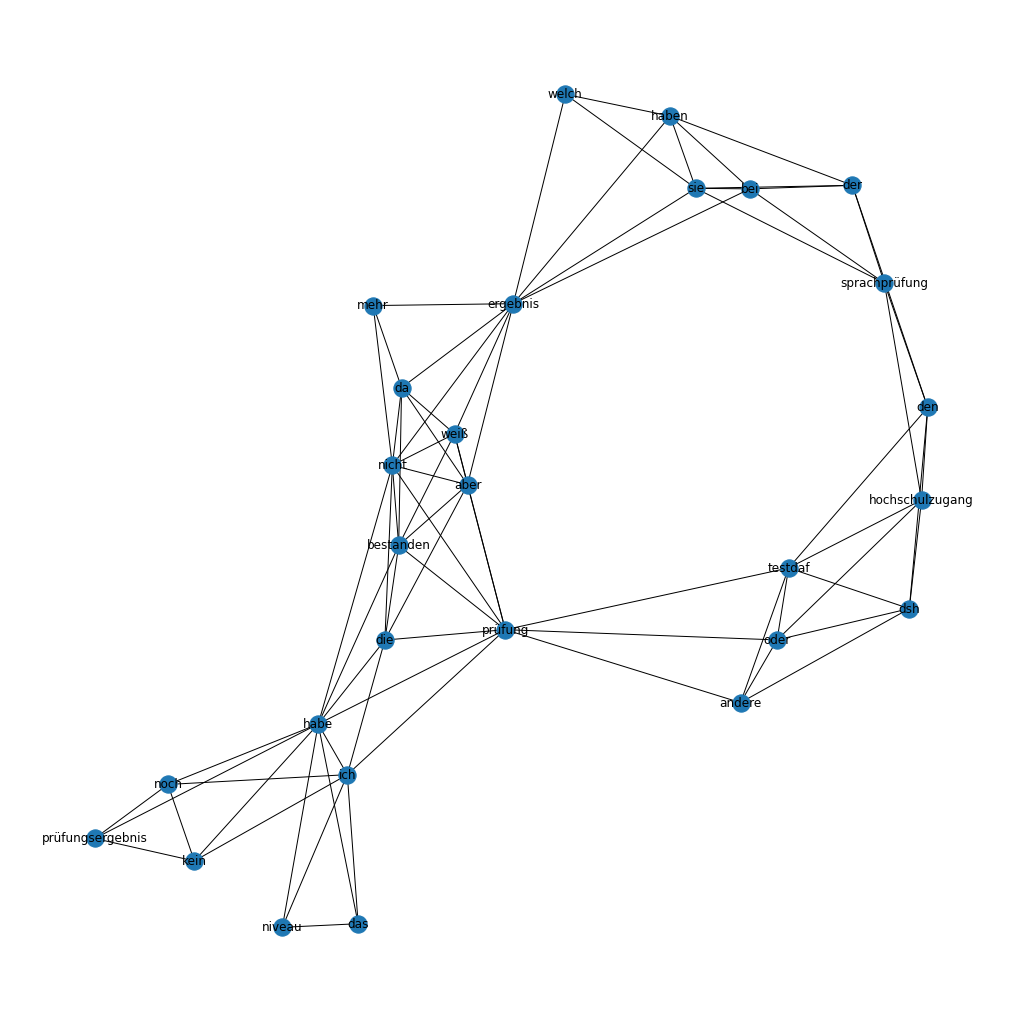

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, text


fig = plt.figure(figsize=(14, 14))
pos = nx.spring_layout(lemma_graph)
d = dict(lemma_graph.degree)

nx.draw(lemma_graph, pos=pos, with_labels=False, font_weight="bold")
# for node, (x, y) in pos.items():
#     text(x, y, node, fontsize=d[node]*5, ha='center', va='center')
nx.draw_networkx_labels(lemma_graph, pos, labels);


# Welche der folgenden Aussagen beschreibt Ihre Situation am besten. 
# Ich warte darauf einen weiteren Sprachkurs oder Schwerpunktkurs besuchen zu können. 
# Ich warte darauf ein Studium beginnen zu können oder suche einen Studienplatz. 
# Ich suche einen Ausbildungsplatz. Ich mache zurzeit eine Berufsausbildung in einem Betrieb oder einer beruflichen Schule

In [57]:
test2

'Welches Ergebnis haben Sie bei der Sprachprüfung für den Hochschulzugang DSH TestDaF oder andere Prüfung erhalten. Ich habe. Ich habe das Niveau. Ich habe die Prüfung bestanden aber weiß das Ergebnis nicht mehr. Ich habe die Prüfung nicht bestanden aber weiß das Ergebnis nicht mehr. Ich habe noch kein Prüfungsergebnis erhalten.'

Now to run the algorithm, we use `PageRank` – a form of
[*eigenvector centrality*](https://derwen.ai/docs/ptr/glossary/#eigenvector-centrality)
– to calculate ranks for each of the nodes in the lemma graph.

In [58]:
ranks = nx.pagerank(lemma_graph)
ranks

{0: 0.0188037584785665,
 1: 0.058092815169109725,
 2: 0.029384190580737175,
 3: 0.03475778934235734,
 4: 0.029362386300588683,
 5: 0.030918408822199626,
 6: 0.031188969276983444,
 7: 0.03145538304179286,
 8: 0.031245742249739483,
 9: 0.031084113665970033,
 10: 0.03489118973708566,
 11: 0.029475624878882938,
 12: 0.024061441922328817,
 13: 0.06115920927724741,
 14: 0.057430574101548545,
 15: 0.0694524032655997,
 16: 0.017862703813676252,
 17: 0.017862703813676252,
 18: 0.039904383097419116,
 19: 0.04496793732146696,
 20: 0.04494403088751163,
 21: 0.0444960435953571,
 22: 0.04491524907709741,
 23: 0.052262249228082355,
 24: 0.02512010817484034,
 25: 0.023032611631088974,
 26: 0.023032611631088974,
 27: 0.018835367617956806}

In [59]:
for node_id, rank in sorted(ranks.items(), key=lambda x: x[1], reverse=True):
    ic(node_id, rank, labels[node_id])

ic| node_id: 15, rank: 0.0694524032655997, labels[node_id]: 'habe'
ic| node_id: 13, rank: 0.06115920927724741, labels[node_id]: 'prüfung'
ic| node_id: 1
    rank: 0.058092815169109725
    labels[node_id]: 'ergebnis'
ic| node_id: 14, rank: 0.057430574101548545, labels[node_id]: 'ich'
ic| node_id: 23, rank: 0.052262249228082355, labels[node_id]: 'nicht'
ic| node_id: 19
    rank: 0.04496793732146696
    labels[node_id]: 'bestanden'
ic| node_id: 20, rank: 0.04494403088751163, labels[node_id]: 'aber'
ic| node_id: 22, rank: 0.04491524907709741, labels[node_id]: 'da'
ic| node_id: 21, rank: 0.0444960435953571, labels[node_id]: 'weiß'
ic| node_id: 18, rank: 0.039904383097419116, labels[node_id]: 'die'
ic| node_id: 10, rank: 0.03489118973708566, labels[node_id]: 'testdaf'
ic| node_id: 3, rank: 0.03475778934235734, labels[node_id]: 'sie'
ic| node_id: 7, rank: 0.03145538304179286, labels[node_id]: 'den'
ic| node_id: 8
    rank: 0.031245742249739483
    labels[node_id]: 'hochschulzugang'
ic| node_i

Define a function to collect the top-ranked phrases from the lemma graph.

In [60]:
import math

def collect_phrases (chunk, phrases, counts):
    chunk_len = chunk.end - chunk.start
    sq_sum_rank = 0.0
    non_lemma = 0
    compound_key = set([])

    for i in range(chunk.start, chunk.end):
        token = doc[i]
        key = (token.lemma_, token.pos_)
        
        if key in seen_lemma:
            node_id = list(seen_lemma.keys()).index(key)
            rank = ranks[node_id]
            sq_sum_rank += rank
            compound_key.add(key)
        
            ic(token.lemma_, token.pos_, node_id, rank)
        else:
            non_lemma += 1
    
    # although the noun chunking is greedy, we discount the ranks using a
    # point estimate based on the number of non-lemma tokens within a phrase
    non_lemma_discount = chunk_len / (chunk_len + (2.0 * non_lemma) + 1.0)

    # use root mean square (RMS) to normalize the contributions of all the tokens
    phrase_rank = math.sqrt(sq_sum_rank / (chunk_len + non_lemma))
    phrase_rank *= non_lemma_discount

    # remove spurious punctuation
    phrase = chunk.text.lower().replace("'", "")

    # create a unique key for the the phrase based on its lemma components
    compound_key = tuple(sorted(list(compound_key)))
    
    if not compound_key in phrases:
        phrases[compound_key] = set([ (phrase, phrase_rank) ])
        counts[compound_key] = 1
    else:
        phrases[compound_key].add( (phrase, phrase_rank) )
        counts[compound_key] += 1

    ic(phrase_rank, chunk.text, chunk.start, chunk.end, chunk_len, counts[compound_key])

Collect the top-ranked phrases based on both the noun chunks and the named entities...

In [61]:
phrases = {}
counts = {}

for chunk in doc.noun_chunks:
    collect_phrases(chunk, phrases, counts)

ic| token.lemma_: 'welch'
    token.pos_: 'VERB'
    node_id: 0
    rank: 0.0188037584785665
ic| token.lemma_: 'Ergebnis'
    token.pos_: 'PROPN'
    node_id: 1
    rank: 0.058092815169109725
ic| phrase_rank: 0.13072156469864252
    chunk.text: 'Welches Ergebnis'
    chunk.start: 0
    chunk.end: 2
    chunk_len: 2
    counts[compound_key]: 1
ic| token.lemma_: 'haben'
    token.pos_: 'PROPN'
    node_id: 2
    rank: 0.029384190580737175
ic| token.lemma_: 'Sie'
    token.pos_: 'PROPN'
    node_id: 3
    rank: 0.03475778934235734
ic| token.lemma_: 'bei'
    token.pos_: 'VERB'
    node_id: 4
    rank: 0.029362386300588683
ic| token.lemma_: 'der'
    token.pos_: 'NOUN'
    node_id: 5
    rank: 0.030918408822199626
ic| token.lemma_: 'Sprachprüfung'
    token.pos_: 'PROPN'
    node_id: 6
    rank: 0.031188969276983444
ic| phrase_rank: 0.14701272824849132
    chunk.text: 'haben Sie bei der Sprachprüfung'
    chunk.start: 2
    chunk.end: 7
    chunk_len: 5
    counts[compound_key]: 1
ic| toke

In [62]:
for ent in doc.ents:
    collect_phrases(ent, phrases, counts)

ic| token.lemma_: 'welch'
    token.pos_: 'VERB'
    node_id: 0
    rank: 0.0188037584785665
ic| token.lemma_: 'Ergebnis'
    token.pos_: 'PROPN'
    node_id: 1
    rank: 0.058092815169109725
ic| phrase_rank: 0.13072156469864252
    chunk.text: 'Welches Ergebnis'
    chunk.start: 0
    chunk.end: 2
    chunk_len: 2
    counts[compound_key]: 2
ic| token.lemma_: 'Sprachprüfung'
    token.pos_: 'PROPN'
    node_id: 6
    rank: 0.031188969276983444
ic| phrase_rank: 0.08830199499018049
    chunk.text: 'Sprachprüfung'
    chunk.start: 6
    chunk.end: 7
    chunk_len: 1
    counts[compound_key]: 1
ic| token.lemma_: 'den'
    token.pos_: 'VERB'
    node_id: 7
    rank: 0.03145538304179286
ic| token.lemma_: 'Hochschulzugang'
    token.pos_: 'PROPN'
    node_id: 8
    rank: 0.031245742249739483
ic| token.lemma_: 'DSH'
    token.pos_: 'PROPN'
    node_id: 9
    rank: 0.031084113665970033
ic| phrase_rank: 0.1326074368371989
    chunk.text: 'den Hochschulzugang DSH'
    chunk.start: 8
    chunk.en

Since noun chunks can be expressed in different ways (e.g., they may have articles or prepositions), we need to find a minimum span for each phrase based on combinations of lemmas...

In [63]:
import operator

min_phrases = {}

for compound_key, rank_tuples in phrases.items():
    l = list(rank_tuples)
    l.sort(key=operator.itemgetter(1), reverse=True)
    
    phrase, rank = l[0]
    count = counts[compound_key]
    
    min_phrases[phrase] = (rank, count)

Then let's examine the results of TextRank...

In [64]:
for phrase, (rank, count) in sorted(min_phrases.items(), key=lambda x: x[1][0], reverse=True):
    ic(phrase, count, rank)

ic| phrase: 'prüfung nicht bestanden aber weiß'
    count: 1
    rank: 0.18552832604546218
ic| phrase: 'prüfung bestanden aber weiß'
    count: 1
    rank: 0.17689193133959868
ic| phrase: 'ich habe', count: 3, rank: 0.16791729271489464
ic| phrase: 'ich habe noch kein prüfungsergebnis'
    count: 1
    rank: 0.1632072507611458
ic| phrase: 'ich habe das niveau', count: 1, rank: 0.16129892001845558
ic| phrase: 'haben sie bei der sprachprüfung'
    count: 1
    rank: 0.14701272824849132
ic| phrase: 'hochschulzugang dsh testdaf oder'
    count: 1
    rank: 0.1423779030786326
ic| phrase: 'den hochschulzugang dsh'
    count: 1
    rank: 0.1326074368371989
ic| phrase: 'welches ergebnis', count: 2, rank: 0.13072156469864252
ic| phrase: 'prüfung', count: 3, rank: 0.12365194021652816
ic| phrase: 'kein prüfungsergebnis'
    count: 1
    rank: 0.09645722051084013
ic| phrase: 'sprachprüfung', count: 1, rank: 0.08830199499018049
ic| phrase: 'niveau', count: 1, rank: 0.06682571326532223


Just for kicks, compare with raw results of the non-chunked lemma nodes...

In [65]:
for node_id, rank in sorted(ranks.items(), key=lambda x: x[1], reverse=True):
    ic(labels[node_id], rank)

ic| labels[node_id]: 'habe', rank: 0.0694524032655997
ic| labels[node_id]: 'prüfung', rank: 0.06115920927724741
ic| labels[node_id]: 'ergebnis', rank: 0.058092815169109725
ic| labels[node_id]: 'ich', rank: 0.057430574101548545
ic| labels[node_id]: 'nicht', rank: 0.052262249228082355
ic| labels[node_id]: 'bestanden', rank: 0.04496793732146696
ic| labels[node_id]: 'aber', rank: 0.04494403088751163
ic| labels[node_id]: 'da', rank: 0.04491524907709741
ic| labels[node_id]: 'weiß', rank: 0.0444960435953571
ic| labels[node_id]: 'die', rank: 0.039904383097419116
ic| labels[node_id]: 'testdaf', rank: 0.03489118973708566
ic| labels[node_id]: 'sie', rank: 0.03475778934235734
ic| labels[node_id]: 'den', rank: 0.03145538304179286
ic| labels[node_id]: 'hochschulzugang', rank: 0.031245742249739483
ic| labels[node_id]: 'sprachprüfung', rank: 0.031188969276983444
ic| labels[node_id]: 'dsh', rank: 0.031084113665970033
ic| labels[node_id]: 'der', rank: 0.030918408822199626
ic| labels[node_id]: 'oder', ra